In [2]:
import pandas as pd
import numpy as np
from math import log10
from math import log
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
DATASET_PATH = 'data/'
AUTH_FILTERED_PATH = 'data/authority_filtered/'
SPIKES_PATH = 'data/spikes/'

DATASET = pd.read_csv(DATASET_PATH + 'ferrero_corporate.csv')
AUTH_FILTERED_DATASET = pd.read_csv(AUTH_FILTERED_PATH + 'ferrero_corp_auth.csv')

C:\Users\alxau\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,4,44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
def get_user_scale():
    s = pd.Series(np.exp(np.linspace(1, 10, 101)))
    return (s -s.min())/ s.max() * 50 + 1


def get_text_weight(df):
    df = df.loc[df['score_engagement'].dropna().index]
    df['percentile'] = get_user_percentile(df['score_engagement'])
    scale = get_user_scale()
    df['text_weighted'] = df['percentile'].apply(lambda x: scale[round(x)])
    return df


def get_user_percentile(series):
    return series.apply(lambda x: stats.percentileofscore(series, x))


def get_days(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex'] > thresh][['mIndex', 'sign']]


# Same as get_days, but on the left or right side of a merged dataset
def get_days_left(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex_x'] > thresh][['mIndex_x', 'sign_x']]


def get_days_right(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex_y'] > thresh][['mIndex_y', 'sign_y']]


def get_polarity(df):
    positive_emotions = ['emotion_joy', 'emotion_admiration']
    negative_emotions = ['emotion_fear', 'emotion_anger', 'emotion_disapproval']
    
    positive = df['emotion_joy'] + df['emotion_admiration']
    positive = positive.fillna(positive.mean())
    
    negative = df['emotion_fear'] + df['emotion_anger'] + df['emotion_disapproval']
    negative = negative.fillna(negative.mean())

    total = positive + negative
    df['sentiment_value'] = positive / total
    return df


def convert_datetime_col_to_iso_format(df, col=None):
    df = df.copy()
    if (not col):
        df = df.reset_index()
        df['date_index'] = df['date_index'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d', errors='coerce').date())
        df = df.set_index(keys=['date_index'])
        return df
    else:
        return df['date_index'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d', errors='coerce').date())


def iris(dataf, weight_by_user=False):
    dataset = dataf.copy()
                       
    if weight_by_user:
        dataset = get_text_weight(dataset)
        
    dataset = get_polarity(dataset)
        
    if weight_by_user:
        dataset = dataset[['date_created_at', 'sentiment_value', 'text_weighted']]
    else:
        dataset = dataset[['date_created_at', 'sentiment_value']]

#     dataset['date_index'] = pd.DatetimeIndex(dataset.date_created_at)
    dataset['date_index'] =  pd.to_datetime(dataset.date_created_at,  errors='coerce')
    dataset = dataset.loc[dataset['date_index'].dropna().index]
    
    volumes = dataset.groupby(pd.Grouper(key='date_index', freq='d')).count()['sentiment_value']
    # print(volumes.head())
    mean_sent = dataset.groupby(pd.Grouper(key='date_index', freq='d')).mean()['sentiment_value']
        
    if weight_by_user:
        tmp = dataset[['date_index', 'text_weighted']]
        weighted_volumes = tmp.groupby(pd.Grouper(key='date_index', freq='d')).sum()['text_weighted']
        volume_medians = weighted_volumes.rolling(window=14).median()
    else:
        volume_medians = volumes.rolling(window=14).median()

    mean_sent_abs = abs(mean_sent - 0.5) + 1

    if weight_by_user:
        index = (weighted_volumes / volume_medians - 1) * mean_sent_abs
        index.replace(to_replace=[np.inf, np.nan], value=0, inplace=True)   # Needed to handle limit cases
    else:
        index = (volumes / volume_medians - 1) * mean_sent_abs
        index.replace(to_replace=[np.inf, np.nan], value=0, inplace=True)   # Needed to handle limit cases

    return pd.DataFrame({'mIndex': index, 
                         'volume': volumes, 
                         'sentiment': mean_sent, 
                         'sign': (mean_sent - 0.5) > 0})


In [5]:
def plot_iris(iris, threshold):

    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    axs = fig.subplots(2,1)

    plt.sca(axs[0])
    plt.xticks(rotation=45)

    axs[0].set_title('Volumes')
    axs[0].grid(True)
    axs[0].plot(iris.index.values, iris['volume'])

    plt.sca(axs[1])
    plt.xticks(rotation=45)

    axs[1].set_title('Alert Spectrum')
    axs[1].grid(True)
    axs[1].plot(iris.index.values, iris['mIndex'])


    print('####  Peaks found ####')
    print(get_days(iris, threshold))

    print('\n####  Charts ####')


In [6]:
import math

# Needed in case we decide to allow infinites in the relevance index
def no_inf_max(values):
    max = 0
    for i in values:
        if not math.isinf(i):
            if i > max:
                max = i
    return max 

def plot_auth_spikes(df, threshold):
    
    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    
    ax = fig.subplots(2,1)
    plt.sca(ax[0])
    plt.xticks(rotation=45)
    
    ax0_auth = ax[0].twinx()

    plt.sca(ax[1])
    plt.xticks(rotation=45)

    ax1_auth = ax[1].twinx()

    color = 'tab:blue'
    max_value_vol = df['volume_y'].max()
    min_value_vol = df['volume_y'].min()

    # Since the relevance index can be negative, we need to shift its values. We also need to watch out for empty values while computing its max
    df_copy = df.copy()

    min_value_mIndex = df['mIndex_x'].min()
    min_value_mIndex = df['mIndex_y'].min()
    if (min_value_mIndex < 0):
        df_copy['mIndex_y'] =  df_copy['mIndex_y'] + abs(min_value_mIndex)
        min_value_mIndex = 0
    max_value_mIndex = no_inf_max(df_copy['mIndex_y'])

    ax[0].set_title('Volumes')
    ax[0].grid(True)
    ax[0].plot(df.index.values, (df['volume_y'] - min_value_vol) / (max_value_vol - min_value_vol), color=color)
    ax[0].tick_params(axis='y', labelcolor=color)

    ax[1].set_title('Alert Spectrum')
    ax[1].grid(True)
    ax[1].plot(df.index.values, (df['mIndex_y'] - min_value_mIndex) / (max_value_mIndex - min_value_mIndex), color=color)
    ax[1].tick_params(axis='y', labelcolor=color)

    color = 'tab:orange'
    max_value_vol = df['volume_x'].max()
    min_value_vol = df['volume_x'].min()
    
    # Since the relevance index can be negative, we need to shift its values. We also need to watch out for empty values while computing its max
    min_value_mIndex = df['mIndex_x'].min()
    if (min_value_mIndex < 0):
        df_copy['mIndex_x'] = df_copy['mIndex_x'] + abs(min_value_mIndex)
        min_value_mIndex = 0
    max_value_mIndex = no_inf_max(df_copy['mIndex_x'])


    ax0_auth.plot(df.index.values, (df['volume_x'] - min_value_vol) / (max_value_vol - min_value_vol), color=color)
    ax0_auth.tick_params(axis='y', labelcolor=color)

    ax1_auth.plot(df.index.values, (df['mIndex_x'] - min_value_mIndex) / (max_value_mIndex - min_value_mIndex), color=color)
    ax1_auth.tick_params(axis='y', labelcolor=color)

####  Peaks found ####
               mIndex   sign
date_index                  
2019-08-20   2.602240  False
2019-08-21  13.554951  False
2019-08-22   5.825910  False
2019-08-23   2.485722  False
2019-08-24   1.006199  False
...               ...    ...
2021-08-19   0.774941   True
2021-08-20   0.858849  False
2021-08-23   2.040529  False
2021-08-24   1.287879  False
2021-08-25   0.679956  False

[165 rows x 2 columns]

####  Charts ####


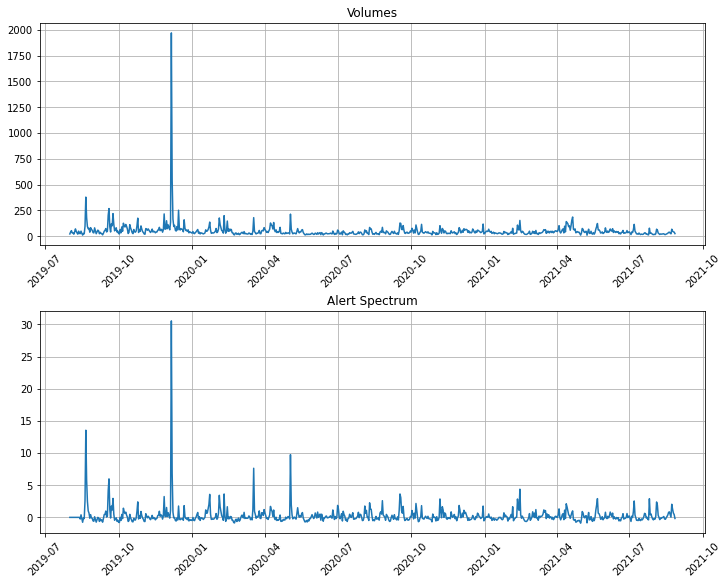

In [7]:
irisres = iris(DATASET)
irisres = convert_datetime_col_to_iso_format(irisres)
plot_iris(irisres, 0.5)

In [8]:
irisres

,mIndex,volume,sentiment,sign
date_index,,,,
2019-08-01,0.000000,21,0.373657,False
2019-08-02,0.000000,40,0.373657,False
2019-08-03,0.000000,53,0.373657,False
2019-08-04,0.000000,31,0.373657,False
2019-08-05,0.000000,31,0.373657,False
...,...,...,...,...
2021-08-23,2.040529,67,0.468272,False
2021-08-24,1.287879,49,0.360722,False
2021-08-25,0.679956,41,0.437569,False


In [9]:
irisres.to_csv(DATASET_PATH + 'irisres.csv')

In [10]:
iris_spikes = irisres.loc[irisres['mIndex'] >= 0.5]
iris_spikes

,mIndex,volume,sentiment,sign
date_index,,,,
2019-08-20,2.602240,96,0.373657,False
2019-08-21,13.554951,378,0.373657,False
2019-08-22,5.825910,179,0.373657,False
2019-08-23,2.485722,93,0.373657,False
2019-08-24,1.006199,71,0.373657,False
...,...,...,...,...
2021-08-19,0.774941,36,0.524922,True
2021-08-20,0.858849,38,0.493919,False
2021-08-23,2.040529,67,0.468272,False


####  Peaks found ####
              mIndex   sign
date_index                 
2019-10-17  1.100317   True
2019-10-23  1.411402  False
2019-10-24  5.524376  False
2019-10-25  1.182024  False
2019-10-30  1.289454   True
2019-10-31  3.668820  False
2019-11-08  2.393225   True
2019-12-01  3.318031  False
2019-12-06  5.530052  False
2019-12-10  2.212021  False
2019-12-13  1.106010  False
2019-12-24  1.036259  False
2020-02-08  1.496028  False
2020-02-10  1.017680  False
2020-02-13  1.463476   True
2020-02-18  1.106010  False
2020-02-19  3.318031  False
2020-02-21  1.106010  False
2020-05-09  1.380941   True
2020-05-14  1.447140  False
2020-10-08  3.318031  False
2021-03-27  1.106010  False
2021-04-16  1.106010  False
2021-04-19  1.106010  False
2021-06-04  1.475816  False

####  Charts ####


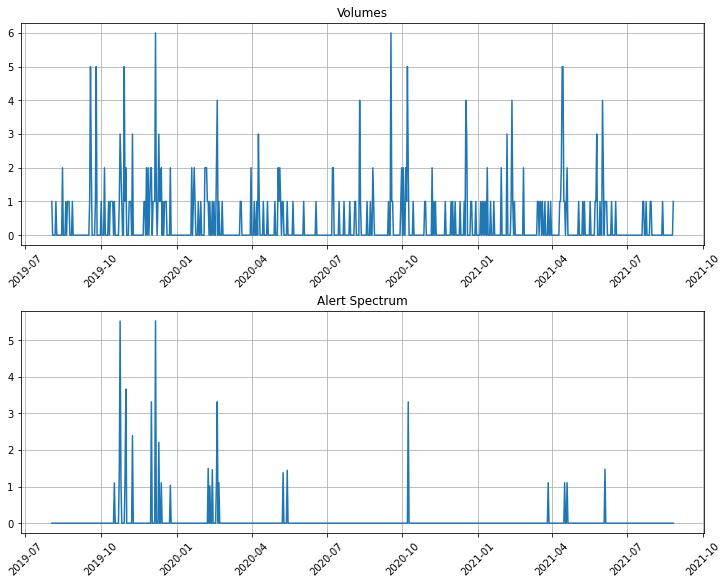

In [11]:
irisres_auth = iris(AUTH_FILTERED_DATASET)
irisres_auth = convert_datetime_col_to_iso_format(irisres_auth)
plot_iris(irisres_auth, 0.5)

In [12]:
irisres_auth

,mIndex,volume,sentiment,sign
date_index,,,,
2019-08-02,0.0,1,0.39399,False
2019-08-03,0.0,0,NaN,False
2019-08-04,0.0,0,NaN,False
2019-08-05,0.0,0,NaN,False
2019-08-06,0.0,0,NaN,False
...,...,...,...,...
2021-08-22,0.0,0,NaN,False
2021-08-23,0.0,0,NaN,False
2021-08-24,0.0,0,NaN,False


In [13]:
iris_auth_spikes = irisres_auth.loc[irisres_auth['mIndex'] >= 0.5]
iris_auth_spikes

,mIndex,volume,sentiment,sign
date_index,,,,
2019-10-17,1.100317,1,0.600317,True
2019-10-23,1.411402,1,0.088598,False
2019-10-24,5.524376,3,0.395125,False
2019-10-25,1.182024,2,0.317976,False
2019-10-30,1.289454,1,0.789454,True
2019-10-31,3.668820,2,0.277060,False
2019-11-08,2.393225,3,0.696613,True
2019-12-01,3.318031,2,0.393990,False
2019-12-06,5.530052,6,0.393990,False


In [14]:
iris_join = irisres.join(irisres_auth, how='left', lsuffix='_x', rsuffix='_y')

In [15]:
iris_join

,mIndex_x,volume_x,sentiment_x,sign_x,mIndex_y,volume_y,sentiment_y,sign_y
date_index,,,,,,,,
2019-08-01,0.000000,21,0.373657,False,NaN,NaN,NaN,NaN
2019-08-02,0.000000,40,0.373657,False,0.0,1.0,0.39399,False
2019-08-03,0.000000,53,0.373657,False,0.0,0.0,NaN,False
2019-08-04,0.000000,31,0.373657,False,0.0,0.0,NaN,False
2019-08-05,0.000000,31,0.373657,False,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...
2021-08-23,2.040529,67,0.468272,False,0.0,0.0,NaN,False
2021-08-24,1.287879,49,0.360722,False,0.0,0.0,NaN,False
2021-08-25,0.679956,41,0.437569,False,0.0,0.0,NaN,False


In [16]:
%matplotlib qt 

In [17]:
plot_auth_spikes(iris_join, 0.5)

In [18]:
merged_spikes_df = iris_join.loc[iris_join['mIndex_x'] >= 0.5 ]
merged_spikes_df

,mIndex_x,volume_x,sentiment_x,sign_x,mIndex_y,volume_y,sentiment_y,sign_y
date_index,,,,,,,,
2019-08-20,2.602240,96,0.373657,False,0.0,0.0,NaN,False
2019-08-21,13.554951,378,0.373657,False,0.0,1.0,0.39399,False
2019-08-22,5.825910,179,0.373657,False,0.0,1.0,0.39399,False
2019-08-23,2.485722,93,0.373657,False,0.0,1.0,0.39399,False
2019-08-24,1.006199,71,0.373657,False,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...
2021-08-19,0.774941,36,0.524922,True,0.0,0.0,NaN,False
2021-08-20,0.858849,38,0.493919,False,0.0,0.0,NaN,False
2021-08-23,2.040529,67,0.468272,False,0.0,0.0,NaN,False


In [19]:
iris_spikes.to_csv(SPIKES_PATH + 'ferrero_corp_spikes.csv')
iris_auth_spikes.to_csv(SPIKES_PATH + 'ferrero_corp_auth_spikes.csv')
merged_spikes_df.to_csv(SPIKES_PATH + 'ferrero_corp_merged.csv')